In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib import cm

In [3]:
import rasterio as rio
import pandas as pd
import seaborn as sns

# Data Load

In [4]:
data = rio.open('sentinel_nrcan.tif')

In [5]:
print(data.width, data.height, data.count, data.bounds, f"\n {data.transform}", "\n", data.crs)
width = data.width
height = data.height
height*width

2500 1771 13 BoundingBox(left=-74.171447754, bottom=45.96451541520898, right=-71.7489624024375, top=47.144897486) 
 | 0.00, 0.00,-74.17|
| 0.00,-0.00, 47.14|
| 0.00, 0.00, 1.00| 
 EPSG:4326


4427500

In [6]:
data_list = []
for i in range(13):
    if i < 9:
        name = f'band{i+1:02d}'
    elif (i == 9)  | (i == 10):
        name = f'band{i+2:02d}'
    elif i == 11:
        name = f'band8a'
    elif i == 12:
        name = f'land_type'
    band_i = pd.Series(data.read(i+1).flatten(), name=name)
    data_list.append(band_i)


In [7]:
for i in range(13):
    print(data_list[i].name, data_list[i][1])

band01 0.3068
band02 0.2572
band03 0.2449
band04 0.2263
band05 0.2482
band06 0.2813
band07 0.2894
band08 0.2943
band09 0.3833
band11 0.2308
band12 0.1814
band8a 0.2921
land_type 6.0


In [8]:
df_raw = pd.concat(data_list, axis=1, keys=[s.name for s in data_list])

In [9]:
df_raw.head()

,band01,band02,band03,band04,band05,band06,band07,band08,band09,band11,band12,band8a,land_type
0,0.2226,0.2033,0.2095,0.1944,0.2104,0.2375,0.2358,0.2584,0.3188,0.1967,0.1273,0.2301,1.0
1,0.3068,0.2572,0.2449,0.2263,0.2482,0.2813,0.2894,0.2943,0.3833,0.2308,0.1814,0.2921,6.0
2,0.3851,0.3290,0.3116,0.3010,0.3312,0.3579,0.3695,0.3420,0.4621,0.2969,0.2354,0.3778,6.0
3,0.4392,0.4069,0.3865,0.3774,0.4114,0.4332,0.4422,0.4113,0.5130,0.3676,0.3126,0.4477,1.0
4,0.4378,0.4235,0.4058,0.3930,0.4168,0.4282,0.4254,0.4364,0.5176,0.3687,0.2783,0.4234,1.0


In [10]:
df_raw.land_type.value_counts()

6.0     1535146
5.0     1131918
15.0     803409
1.0      347161
18.0     338687
17.0     151530
8.0       40241
14.0      36066
16.0      26417
10.0      16925
Name: land_type, dtype: int64

# ML Classifier

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

## Data prep

In [66]:
SAMPLE_SIZE = int(5e3)
df = df_raw[0:SAMPLE_SIZE]

In [67]:
df.land_type.value_counts()

6.0     2230
5.0     1197
1.0      804
18.0     437
8.0      129
14.0      79
10.0      68
16.0      44
17.0      10
15.0       2
Name: land_type, dtype: int64

### Normalizing feature values

In [68]:
y = df.land_type
X = df.drop(['land_type'], axis=1)
columns = X.columns

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Training the model

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4000, 12) (1000, 12) (4000,) (1000,)


In [70]:
clf=RandomForestClassifier(n_estimators=200, max_features='sqrt', min_samples_leaf=2, max_depth=10)
clf.fit(X_train,y_train)


## Prediction

In [ ]:
y_pred=clf.predict(X_test)

In [71]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.496


In [80]:
y_pred[0:100]

array([ 6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  5.,
        6.,  1.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  5.,  6.,  6.,
        6.,  6.,  6.,  1.,  6.,  1.,  6.,  6.,  6.,  6.,  6.,  1.,  6.,
        6.,  6.,  6.,  5.,  5.,  5.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  1.,  6.,  6.,  6.,  5.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
       18.,  5.,  6.,  6.,  6.,  6.,  6., 18.,  5.,  6.,  6.,  6.,  5.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  5.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  1., 18., 18.,  6.], dtype=float32)

### Confusion matrix

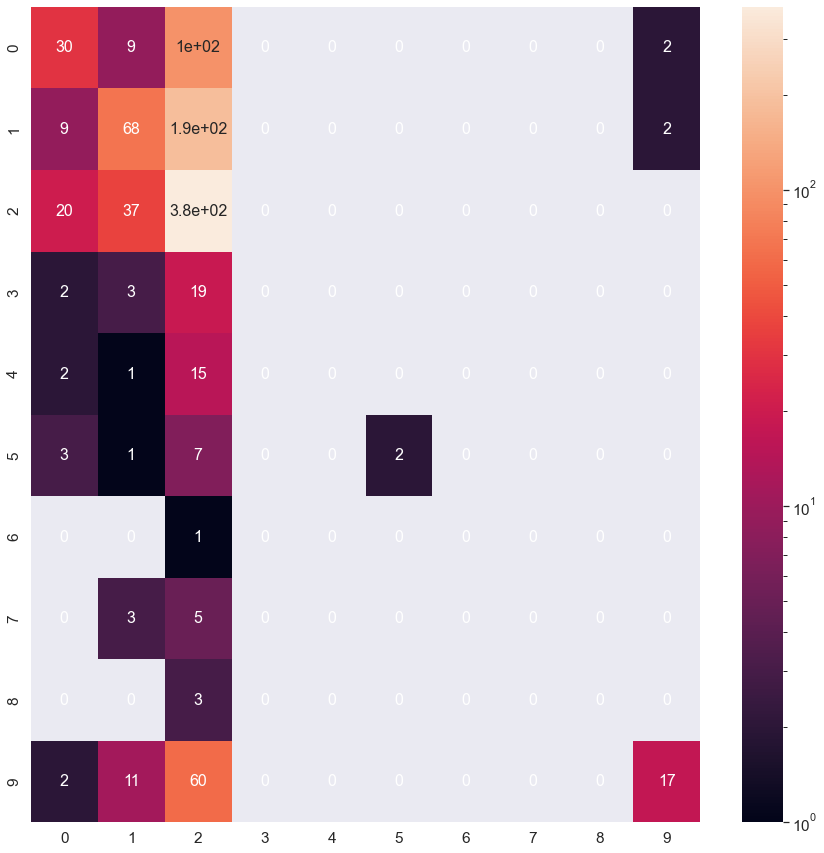

In [72]:
from matplotlib.colors import LogNorm, Normalize
results = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(results, range(10), range(10))
plt.figure(figsize=(15,15))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, norm=LogNorm()) # font size
plt.show()

## Model Interpretation

In [82]:
pd.Series(clf.feature_importances_, index=['1', '2', '3', '4', '5', '6', '7', '8','9','11','12','8a']).sort_values(ascending=False)

12    0.104299
11    0.101436
9     0.099431
1     0.095801
8a    0.094142
8     0.085731
7     0.078586
2     0.077536
5     0.066588
6     0.066498
4     0.065195
3     0.064757
dtype: float64

# Data visualization

In [ ]:
#### Example plotting functions to display S2 data in Python

def show_band_matrix():
    fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(50,25))
    plt.suptitle("Sentinel-2 Bands", fontsize=60)
    band_count = 1
    for i,ax_row in enumerate(axes):
        for j, ax_col in enumerate(ax_row):
            if i == 0: # Multichannel bands
                title = IMG_TITLES[j]
                imband = np.asarray([np.asarray(df[BAND_NAMES[j]]).reshape( \
                         WIDTH, HEIGHT), np.asarray(df[BAND_NAMES[j]+'_1']).reshape(WIDTH, \
                         HEIGHT), np.asarray(df[BAND_NAMES[j]+'_1_2']).reshape(WIDTH, HEIGHT)]).T
            elif i == 2 and j == 3: # Special case for 8a band
                title = 'b8a'
                imband = np.asarray(df[title]).reshape(WIDTH, HEIGHT).T
                band_count += 1
            else: # Individual bands
                title = 'b' + str(band_count).zfill(2)
                imband = np.asarray(df[title]).reshape(WIDTH, HEIGHT).T
                band_count += 1
            
            axes[i][j].set_title(title)
            axes[i][j].imshow(imband, aspect='auto')
            axes[i][j].set_axis_off()

def show_land_cover():
    fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(40,15))
    ax.set_title("NRCan - 2015 Land Cover of Canada")
    cmap = cm.get_cmap('jet', 7)    # 11 discrete colors
    im = ax.imshow(np.asarray(df.land_cover).reshape(WIDTH, HEIGHT).T, cmap=cmap, aspect='auto')
    ax.set_axis_off()
    cbar = plt.colorbar(im, ax=ax)
    tick_locs = (np.arange(7) + 0.5)*(7-1)/7
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels(LAND_COVER_TYPES)
    
    ax2.grid(linestyle='--')
    dp = sns.distplot(df.land_cover, hist=False, kde_kws=dict(linewidth=8))
    ax2.set_xticks(np.arange(7))
    ax2.set_xticklabels(LAND_COVER_TYPES, fontsize=20)
    l1 = ax2.lines[0]
    x1 = l1.get_xydata()[:,0]
    y1 = l1.get_xydata()[:,1]
    ax2.fill_between(x1,y1, color="#5471ab", alpha=0.3)
    ax2.set_xlabel("Land Cover Type")
    ax2.set_title("Land Cover Density")

show_band_matrix()
show_land_cover()

